In [1]:
import numpy as np
import pickle
import numpy as np
import pickle
from copy import deepcopy
from itertools import chain
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 50
from IPython.display import display, HTML
import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from mela.prepare_dataset import Dataset_Gen
from mela.util import plot_matrices, make_dir, get_struct_str, get_args, Early_Stopping, record_data, manifold_embedding, get_args, make_dir, sort_two_lists
from mela.settings.filepath import variational_model_PATH
from mela.settings.global_param import COLOR_LIST
from mela.pytorch.net import Net
from mela.variational.variational_meta_learning import Master_Model, Statistics_Net, Generative_Net, load_model_dict
from mela.variational.variational_meta_learning import VAE_Loss, sample_Gaussian, clone_net, get_nets, get_tasks, evaluate, get_reg, load_trained_models, get_relevance
from mela.variational.variational_meta_learning import plot_task_ensembles, plot_individual_tasks, plot_statistics_vs_z, plot_data_record
from mela.variational.variational_meta_learning import plot_few_shot_loss, plot_individual_tasks_bounce
from mela.variational.variational_meta_learning import get_latent_model_data, get_polynomial_class, get_Legendre_class, get_master_function
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
def parse_dict(filename):
    filename_split = filename.split("_")
    data_dict = {}
    filename_split = filename.split("_")
    data_dict["input_size"] = filename_split[filename_split.index("input") + 1]
    data_dict["statistics_output_neurons"] = filename_split[filename_split.index("stat") + 1]
    data_dict["pre_pooling_neurons"] = filename_split[filename_split.index("pre") + 1]
    data_dict["num_context_neurons"] = filename_split[filename_split.index("context") + 1]
    data_dict["statistics_pooling"] = filename_split[filename_split.index("pool") + 1]
    data_dict["batch_size_task"] = filename_split[filename_split.index("batch") + 1]
    data_dict["num_backwards"] = filename_split[filename_split.index("back") + 1]
    data_dict["is_VAE"] = filename_split[filename_split.index("VAE") + 1]
    data_dict["VAE_beta"] = filename_split[filename_split.index("VAE") + 2]
    data_dict["lr"] = filename_split[filename_split.index("lr") + 1]
    data_dict["reg_amp"] = filename_split[filename_split.index("reg") + 1]
    data_dict["activation_gen"] = filename_split[filename_split.index("actgen") + 1]
    data_dict["activation_model"] = filename_split[filename_split.index("actmodel") + 1]
    data_dict["struct_string"] = filename_split[filename_split.index("struct") + 1]
    data_dict["loss_core"] = filename_split[filename_split.index("core") + 1]
    if "uncertainty" in filename_split:
        data_dict["is_uncertainty"] = eval(filename_split[filename_split.index("uncer") + 1])
    optim_mode = filename_split[filename_split.index("struct") + 2]
    if optim_mode in ["sum", "indi"]:
        data_dict["optim_mode"] = optim_mode
    data_dict["exp_id"] = filename_split[filename_split.index("core") + 2]
    data_dict["filename"] = filename
    return data_dict

## Obtain testing tasks:

In [ ]:
exp_id = "May2"
filename = "Net_['master_tanh']_input_1_(100,100)_statistics-neurons_4_pre_100_pooling_max_context_0_batch_100_backward_1_VAE_False_0.2_uncertainty_False_lr_5e-05_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_struct_60Si-60Si-60Si_individual_core_huber_test2_info"

exp_id = "May3"
filename = "Net_('bounce-states',)_input_6_(100,50)_stat_8_pre_400_pool_max_context_0_hid_(40, 40)_batch_100_back_1_VAE_False_0.2_uncer_False_lr_5e-05_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_struct_60Si-60Si-60Si_indi_core_huber_May3_info"

dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = dirname + filename
is_model_dict = True
if is_model_dict:
    info_dict = pickle.load(open(filename + ".p", "rb"))
    master_model = load_model_dict(info_dict["model_dict"][-1])
    data_record = info_dict["data_record"]
else:
    statistics_Net, generative_Net, data_record = load_trained_models(filename)

filename_split = filename.split("_")
task_id_list = eval("_".join(filename_split[filename_split.index('good/Net'.format(exp_id)) + 1: filename_split.index("input")]))
task_settings = data_record["task_settings"][0]
print("task_settings:\n", task_settings)
is_VAE = eval(filename_split[filename_split.index("VAE") + 1])
is_uncertainty_net = eval(filename_split[filename_split.index("uncertainty") + 1]) if "uncertainty" in filename_split else False
num_test_tasks = 100
task_settings["num_examples"] = 2000
task_settings["test_size"] = 0.2
tasks_train, tasks_test = get_tasks(task_id_list, 1, num_test_tasks, task_settings = task_settings)

## General performance:

In [ ]:
# See the general performance of all
data_dict_list = []
for filename in os.listdir(dirname):
    if "info" not in filename:
        continue
    info_dict = pickle.load(open(dirname + filename, "rb"))
    data_dict = parse_dict(filename)
    master_model = load_model_dict(info_dict["model_dict"][-1])
    print("\n{0}".format(filename))
    
    data_dict["mse_few_shot"] = plot_few_shot_loss(master_model, tasks_test)
    plot_data_record(info_dict["data_record"], is_VAE = is_VAE)
    data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-6:-1])
    data_dict["median_last"] = np.mean(data_record['mse_median_test'][-6:-1])
    data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
    data_dict["median_min"] = np.min(data_record['mse_median_test'])
    statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model.statistics_Net, master_model.generative_Net, is_VAE = is_VAE, title = "y_pred_test vs. y_test")
    print("test statistics vs. z:")
    data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
    if "bounce" in task_id_list[0]:
        plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, master_model = master_model, num_shots = 200)
    else:
        _ = plot_individual_tasks(tasks_test, master_model.statistics_Net, master_model.generative_Net, is_VAE = is_VAE, xlim = task_settings["xlim"])
    data_dict_list.append(data_dict)

## Three different analysis:

In [ ]:
# plot_types = ["standard"]
plot_types = ["gradient"]
# plot_types = ["slider"]

for plot_type in plot_types:
    if plot_type == "standard":
        plot_data_record(data_record, is_VAE = is_VAE)

        statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, statistics_Net, generative_Net, is_VAE = is_VAE, title = "y_pred_test vs. y_test")
        print("test statistics vs. z:")
        plot_statistics_vs_z(z_list_test, statistics_list_test)
        _ = plot_individual_tasks(tasks_test, statistics_Net, generative_Net, is_VAE = is_VAE, xlim = task_settings["xlim"])

    elif plot_type == "gradient":
        batch_size = 256
        sample_task_id = task_id_list[0] + "_{0}".format(np.random.randint(num_test_tasks))
        print("sample_task_id: {0}".format(sample_task_id))
        ((X_train, y_train), (X_test, y_test)), _ = tasks_test[sample_task_id]
        epochs_statistics = 50
        lr_statistics = 1e-3
        optim_type_statistics = "adam"

        # epochs = 50
        # lr = 1e-3
        # optimizer = "adam"

        epochs = 50
        lr = 1e-3
        optim_type = "adam"

        master_model.get_statistics(X_train, y_train)
        y_pred = master_model(X_test)
        loss_list_0 = master_model.latent_param_quick_learn(X_train, y_train, validation_data = (X_test, y_test), batch_size = batch_size, 
                                                            epochs = epochs_statistics, lr = lr_statistics, optim_type = optim_type_statistics)
        y_pred_new = master_model(X_test)
        plt.plot(X_test.data.numpy(), y_test.data.numpy(), ".b", label = "target", markersize = 2, alpha = 0.6)
        plt.plot(X_test.data.numpy(), y_pred.data.numpy(), ".r", label = "initial", markersize = 2, alpha = 0.6)
        plt.plot(X_test.data.numpy(), y_pred_new.data.numpy(), ".y", label = "optimized", markersize = 2, alpha = 0.6)
        plt.plot(X_train.data.numpy(), y_train.data.numpy(), ".k", markersize = 5, label = "training points")
        plt.title("Only optimizing latent variable, validation")
        plt.legend()
        plt.show()

        master_model.get_statistics(X_train, y_train)
        master_model.use_clone_net(clone_parameters = True)
        y_pred = master_model(X_test)
        loss_list_1 = master_model.clone_net_quick_learn(X_train, y_train, validation_data = (X_test, y_test), batch_size = batch_size, 
                                                         epochs = epochs, lr = lr, optim_type = optim_type)
        y_pred_new = master_model(X_test)
        plt.plot(X_test.data.numpy(), y_test.data.numpy(), ".b", label = "target", markersize = 2, alpha = 0.6)
        plt.plot(X_test.data.numpy(), y_pred.data.numpy(), ".r", label = "initial", markersize = 2, alpha = 0.6)
        plt.plot(X_test.data.numpy(), y_pred_new.data.numpy(), ".y", label = "optimized", markersize = 2, alpha = 0.6)
        plt.plot(X_train.data.numpy(), y_train.data.numpy(), ".k", markersize = 5, label = "training points")
        plt.legend()
        plt.title("Optimizing cloned net, validation")
        plt.show()

        master_model.get_statistics(X_train, y_train)
        master_model.use_clone_net(clone_parameters = False)
        W_core, _ = master_model.cloned_net.get_weights_bias(W_source = "core")
        y_pred = master_model(X_test)
        loss_list_2 = master_model.clone_net_quick_learn(X_train, y_train, validation_data = (X_test, y_test), batch_size = batch_size, 
                                                         epochs = epochs, lr = lr, optim_type = optim_type)
        y_pred_new = master_model(X_test)
        plt.plot(X_test.data.numpy(), y_test.data.numpy(), ".b", label = "target", markersize = 3, alpha = 0.6)
        plt.plot(X_test.data.numpy(), y_pred.data.numpy(), ".r", label = "initial", markersize = 3, alpha = 0.6)
        plt.plot(X_test.data.numpy(), y_pred_new.data.numpy(), ".y", label = "optimized", markersize = 3, alpha = 0.6)
        plt.plot(X_train.data.numpy(), y_train.data.numpy(), ".k", markersize = 5, label = "training points")
        plt.xlabel("epochs")
        plt.ylabel("mse loss")
        plt.legend()
        plt.title("Optimizing from_scratch, validation")
        plt.show()

        plt.plot(range(len(loss_list_0)), loss_list_0, label = "loss_optim_latent_param")
        plt.plot(range(len(loss_list_1)), loss_list_1, label = "loss_clone")
        plt.plot(range(len(loss_list_2)), loss_list_2, label = "loss_scratch")
        plt.legend()
        plt.show()
        plt.semilogy(range(len(loss_list_0)), loss_list_0, label = "loss_optim_latent_param")
        plt.semilogy(range(len(loss_list_1)), loss_list_1, label = "loss_clone")
        plt.semilogy(range(len(loss_list_2)), loss_list_2, label = "loss_scratch")

        plt.legend()
        plt.show()

    elif plot_type == "slider":
        from matplotlib.widgets import Slider, Button, RadioButtons
        import matplotlib
        num_tasks_sampled = 10
        rand_id = sorted(np.random.randint(num_test_tasks, size = num_tasks_sampled))
        task_dict = {}
        sample_task_ids = []
        for i, idx in enumerate(rand_id):
            sample_task_id = task_id_list[0] + "_{0}".format(idx)
            sample_task_ids.append(sample_task_id)
            ((X_train, y_train), (X_test, y_test)), _ = tasks_test[sample_task_id]
            if i == 0:
                X_test_0, y_test_0 = X_test, y_test
                X_train_0, y_train_0 = X_train, y_train
            task_dict[sample_task_id] = [[X_train, y_train], [X_test, y_test]]
        X_train, y_train = X_train_0, y_train_0
        X_test, y_test = X_test_0, y_test_0

        if is_VAE:
            statistics = statistics_Net(torch.cat([X_train, y_train], 1))[0][0]
        else:
            statistics = statistics_Net(torch.cat([X_train, y_train], 1))[0]
        statistics_numpy = statistics.data.numpy()
        relevance = get_relevance(X_train, y_train, statistics_Net)
        pred = generative_Net(X_test, statistics)
        W_core, _ = generative_Net.get_weights_bias(W_source = "core")
        num_layers = len(W_core)

        fig, ax = plt.subplots(figsize = (9, 7.5))
        plt.subplots_adjust(left=0.25, bottom=0.27)
        ss0, ss1, ss2, ss3 = statistics_numpy.squeeze().tolist()
        subplt1 = plt.subplot2grid((3, num_layers), (0,0), rowspan = 2, colspan = num_layers)

        l_button_test, = subplt1.plot(X_test.data.numpy(), y_test.data.numpy(), ".r", markersize = 2, alpha = 0.6, label = "testing target")
        l_button, = subplt1.plot(X_train.data.numpy(), y_train.data.numpy(), ".k", markersize = 4, alpha = 0.6, label = "training point")
        # subplt1.scatter(X_train.data.numpy(), y_train.data.numpy(), s = relevance * 5 + 1, c = "k", alpha = 0.6)
        if is_uncertainty_net:
            statistics_logvar = statistics_Net(torch.cat([X_train, y_train], 1))[1]
            pred_std = torch.exp(master_model.generative_Net_logstd(X_test, statistics_logvar))
            l_errormean, _, l_errorbar = subplt1.errorbar(X_test.data.numpy().squeeze(), pred.data.numpy().squeeze(), yerr = pred_std.data.numpy().squeeze(), color = "b", fmt = ".", markersize = 1, alpha = 0.2)
        else:
            l, = subplt1.plot(X_test.data.numpy(), pred.data.numpy(),'.b', markersize = 2, alpha = 0.6, label = "predicted")
        subplt1.axis([task_settings["xlim"][0], task_settings["xlim"][1], -5, 5])
        subplt1.legend()

        subplt2s = []
        for i in range(num_layers):
            subplt2 = plt.subplot2grid((3, num_layers), (2, i))
            scale_min = np.floor(np.min(W_core[i]))
            scale_max = np.ceil(np.max(W_core[i]))
            subplt2.matshow(W_core[i], cmap = matplotlib.cm.binary, vmin = scale_min, vmax = scale_max)
            subplt2.set_xticks(np.array([]))
            subplt2.set_yticks(np.array([]))
            subplt2.set_xlabel("({0:.3f}, {1:.3f})".format(scale_min, scale_max), fontsize = 10)

        axcolor = 'lightgoldenrodyellow'
        ax0 = plt.axes([0.25, 0.08, 0.65, 0.025], facecolor=axcolor)
        ax1 = plt.axes([0.25, 0.12, 0.65, 0.025], facecolor=axcolor)
        ax2 = plt.axes([0.25, 0.16, 0.65, 0.025], facecolor=axcolor)
        ax3 = plt.axes([0.25, 0.2, 0.65, 0.025], facecolor=axcolor)

        s0 = Slider(ax0, 'Statistics[0]', -3, 3, valinit=ss0)
        s1 = Slider(ax1, 'Statistics[1]', -3, 3, valinit=ss1)
        s2 = Slider(ax2, 'Statistics[2]', -3, 3, valinit=ss2)
        s3 = Slider(ax3, 'Statistics[3]', -3, 3, valinit=ss3)

        def update(val):
            (X_train, y_train), (X_test, y_test) = task_dict[radio.value_selected]
            statistics_numpy = np.array([[s0.val, s1.val, s2.val, s3.val]])
            statistics = Variable(torch.FloatTensor(statistics_numpy))
            pred = generative_Net(X_test, statistics)
            l.set_ydata(pred.data.numpy())
            l.set_xdata(X_test.data.numpy())
            W_core, _ = generative_Net.get_weights_bias(W_source = "core")
            for i in range(num_layers):
                subplt2 = plt.subplot2grid((3, num_layers), (2, i))
                scale_min = np.floor(np.min(W_core[i]))
                scale_max = np.ceil(np.max(W_core[i]))
                subplt2.matshow(W_core[i], cmap = matplotlib.cm.binary, vmin = scale_min, vmax = scale_max)
                subplt2.set_xticks(np.array([]))
                subplt2.set_yticks(np.array([]))
                subplt2.set_xlabel("({0:.3f}, {1:.3f})".format(scale_min, scale_max), fontsize = 10)
            fig.canvas.draw_idle()
        s0.on_changed(update)
        s1.on_changed(update)
        s2.on_changed(update)
        s3.on_changed(update)

        resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
        button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
        button.label.set_fontsize(8)

        def reset(event):
            s0.reset()
            s1.reset()
            s2.reset()
            s3.reset()
        button.on_clicked(reset)

        rax = plt.axes([0.025, 0.5 - 0.01 * num_tasks_sampled, 0.18, 0.03 * num_tasks_sampled], facecolor = axcolor)
        radio = RadioButtons(rax, sample_task_ids, active=0)

        def update_y_test(label):
            # Update the target_data:
            (X_train, y_train), (X_test, y_test) = task_dict[label]
            l_button.set_ydata(y_train.data.numpy())
            l_button.set_xdata(X_train.data.numpy())
            l_button_test.set_ydata(y_test.data.numpy())
            l_button_test.set_xdata(X_test.data.numpy())

            # Update the fitted data:
            if is_VAE:
                statistics = statistics_Net(torch.cat([X_train, y_train], 1))[0][0]
            else:
                statistics = statistics_Net(torch.cat([X_train, y_train], 1))[0]
            pred = generative_Net(X_test, statistics)
            if is_uncertainty_net:
                statistics_logvar = statistics_Net(torch.cat([X_test, y_test], 1))[1]
                pred_std = torch.exp(master_model.generative_Net_logstd(X_test, statistics_logvar))
                l_errormean.set_xdata(X_test.data.numpy())
                l_errormean.set_ydata(pred.data.numpy())
                print(torch.cat([pred-pred_std, pred+pred_std], 1).data.numpy().shape)
                l_errorbar[0].set_verts(torch.cat([pred-pred_std, pred+pred_std], 1).data.numpy())
            else:
                l.set_xdata(X_test.data.numpy())
                l.set_ydata(pred.data.numpy())


            # Update the slider
            ss0, ss1, ss2, ss3 = statistics.data.numpy().squeeze().tolist()
            s0.set_val(ss0)
            s1.set_val(ss1)
            s2.set_val(ss2)
            s3.set_val(ss3)

            fig.canvas.draw_idle()
        radio.on_clicked(update_y_test)

        plt.show()

## Interpretability, active learning:

In [3]:
def sort_datapoints(X, y, score, top = None):
    combined_data = torch.cat([X, y], 1)
    isTorch = False
    if isinstance(score, Variable):
        score = score.squeeze().data.numpy()
    if isinstance(X, Variable):
        isTorch = True
    score_sorted, data_sorted = sort_two_lists(score, combined_data.data.numpy(), reverse = True)
    data_sorted = np.array(data_sorted)
    score_sorted = np.array(score_sorted)
    X_sorted, y_sorted = data_sorted[:,0], data_sorted[:,1]
    if top is not None:
        X_sorted = X_sorted[:top]
        y_sorted = y_sorted[:top]
        score_sorted = score_sorted[:top]
    if isTorch:
        X_sorted = Variable(torch.FloatTensor(X_sorted)).contiguous().view(-1,X.size(1))
        y_sorted = Variable(torch.FloatTensor(y_sorted)).contiguous().view(-1,y.size(1))
    return X_sorted, y_sorted, score_sorted


def get_grad_statistics(statistics_Net, X_to_predict, X, y):
    """Obtain gradient of output w.r.t. latent parameters"""
    grads = {}
    def save_grad(name):
        def hook(grad):
            grads[name] = grad
        return hook
    for parameter in statistics_Net.parameters():
        parameter.requires_grad = True
    statistics_few = statistics_Net.forward_inputs(X, y)[0]
    statistics_few.register_hook(save_grad("grad_statistics"))
    y_pred = generative_Net(X_to_predict, statistics_few)
    y_pred.backward()
    grad_statistics = grads['grad_statistics']
    return grad_statistics


def get_sensitivity_ele(statistics_Net, generative_Net, X_to_measure, X_to_predict, X, y):
    statistics_few = statistics_Net.forward_inputs(X, y)[0]
    y_new_estimate = generative_Net(X_to_measure, statistics_few)
    grad_statistics_few = get_grad_statistics(statistics_Net, X_to_predict, X, y)
    for parameter in statistics_Net.parameters():
        parameter.requires_grad = False
    y_new_perturb = Variable(y_new_estimate.data, requires_grad = True)
    y_concat = torch.cat([y_sorted, y_new_perturb], 0)
    X_concat = torch.cat([X_sorted, X_to_measure])
    statistics_new_perturb = statistics_Net.forward_inputs(X_concat, y_concat)[0]
    torch.autograd.backward([statistics_new_perturb], [grad_statistics_few])
    return y_new_perturb.grad


def get_sensitivity(statistics_Net, generative_Net, X_to_measure, X_to_predict, X, y):
    sensitivity_list = []
    for x in X_to_measure:
        x = x.unsqueeze(1)
        sensitivity = get_sensitivity_ele(statistics_Net, generative_Net, X_to_measure = x, X_to_predict = X_to_predict, X = X, y = y)
        sensitivity_list.append(sensitivity)
    sensitivity_list = torch.cat(sensitivity_list, 0)
    return sensitivity_list


def measure_next_point(X_to_predict, X_current, y_current, relevance_current, dataset):
    (X_train, y_train), (X_test, y_test) = dataset

    # Plot current datapoints:
    plt.figure(figsize = (8,6))
    plt.scatter(X_current, y_current, s = 17 * relevance_current + 0.1, c = "r", label = "top-{0} relevant points".format(len(X_current)))

    # Plot current predictions:
    statistics_few = statistics_Net.forward_inputs(X_current, y_current)[0]
    y_pred_few = generative_Net(X_test, statistics_few)
    plt.plot(X_test.data.numpy(), y_pred_few.data.numpy(), ".", c = "orange", markersize = 2, label = "predition with top {0} relevant data points".format(len(X_current)))

    # Plot estimate of prediction point:
    y_to_predict_estimate = generative_Net(X_to_predict, statistics_few)
    plt.scatter(X_to_predict.data.numpy(), y_to_predict_estimate.data.numpy(), s = 100, c = "k", label = "Point to better estimate")

    # Get sensitivity of prediction point w.r.t. each training point:
    sensitivity_list = get_sensitivity(statistics_Net, generative_Net, X_train, X_to_predict, X_current, y_current)
    X_sensitivity_sorted, y_sensitivity_sorted, sensitivity_sorted = sort_datapoints(X_train, y_train, sensitivity_list)
    X_to_measure = X_sensitivity_sorted[:1]
    y_to_measure = y_sensitivity_sorted[:1]

    # Plot the next top point to measure:
    plt.scatter(X_train.data.numpy(), y_train.data.numpy(), s = 10 * np.abs(sensitivity_list.data.numpy()))
    plt.scatter(X_to_measure, y_to_measure, s = sensitivity_sorted[0] * 100, c = "b", label = "New point to measure")
    plt.title("Relevance of each example for determining the latent parameter z")

    # Plot the predictions after measuring the new point:
    X_with_new_measurement = deepcopy(torch.cat([X_current, X_to_measure]))
    y_with_new_measurement = deepcopy(torch.cat([y_current, y_to_measure]))
    statistics_with_new_measurement = statistics_Net.forward_inputs(X_with_new_measurement, y_with_new_measurement)[0]
    y_pred_with_new_measurement = generative_Net(X_test, statistics_with_new_measurement)
    plt.plot(X_test.data.numpy(), y_pred_with_new_measurement.data.numpy(), ".", c = "b", markersize = 2, label = "Predition with new measurement point")
    plt.legend()
    plt.show()
    return X_with_new_measurement, y_with_new_measurement

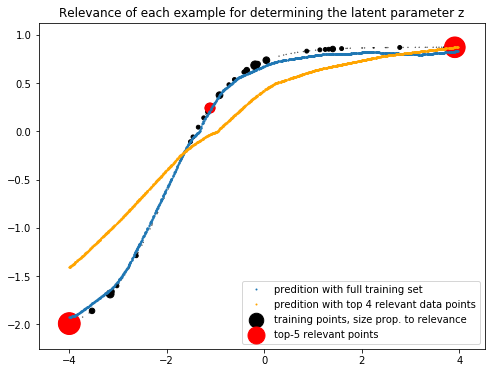

In [5]:
top = 3
plt.figure(figsize = (8,6))
# Get sorted data points according to relevance:
relevance_train = get_relevance(X_train, y_train, statistics_Net)
X_sorted, y_sorted, relevance_sorted = sort_datapoints(X_train, y_train, relevance_train, top = top)

plt.scatter(X_train.data.numpy(), y_train.data.numpy(),  s = 15 * relevance_train + 0.1, c = "k", label = "training points, size prop. to relevance")
plt.scatter(X_sorted, y_sorted, s = 17 * relevance_sorted + 0.1, c = "r", label = "top-5 relevant points")

# Plot prediction with full training set:
statistics = statistics_Net.forward_inputs(X_train, y_train)
y_pred = generative_Net(X_test, statistics[0])
plt.plot(X_test.data.numpy(), y_pred.data.numpy(), ".", markersize = 2, label = "predition with full training set")

# Plot prediction with top few data points
statistics_few = statistics_Net.forward_inputs(X_sorted, y_sorted)
y_pred_few = generative_Net(X_test, statistics_few[0])
plt.plot(X_test.data.numpy(), y_pred_few.data.numpy(), ".", color = "orange", markersize = 2, label = "predition with top 4 relevant data points")
plt.title("Relevance of each example for determining the latent parameter z")
plt.legend()
plt.show()

In [8]:
X_to_predict = -2
X_to_predict = Variable(torch.FloatTensor([[X_to_predict]]))
dataset = tasks_test[sample_task_id][0]
(X_train, y_train), (X_test, y_test) = dataset

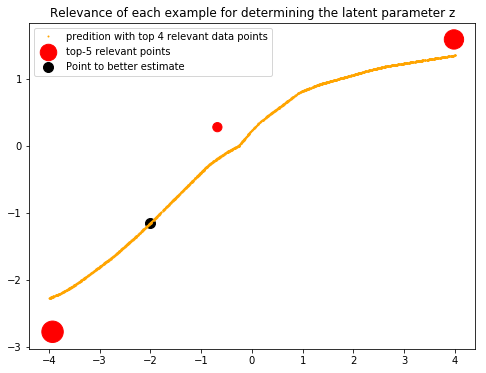

In [9]:
# Only plotting predictions with three points:
top = 3
plt.figure(figsize = (8,6))
# Get sorted data points according to relevance:
relevance_train = get_relevance(X_train, y_train, statistics_Net)
X_sorted, y_sorted, relevance_sorted = sort_datapoints(X_train, y_train, relevance_train, top = top)

plt.scatter(X_sorted, y_sorted, s = 17 * relevance_sorted + 0.1, c = "r", label = "top-5 relevant points")


# Plot prediction with top few data points
statistics_few = statistics_Net.forward_inputs(X_sorted, y_sorted)[0]
y_pred_few = generative_Net(X_test, statistics_few)

y_to_predict_estimate = generative_Net(X_to_predict, statistics_few)
plt.scatter(X_to_predict.data.numpy(), y_to_predict_estimate.data.numpy(), s = 100, c = "k", label = "Point to better estimate")

plt.plot(X_test.data.numpy(), y_pred_few.data.numpy(), ".", color = "orange", markersize = 2, label = "predition with top 4 relevant data points")
plt.title("Relevance of each example for determining the latent parameter z")
plt.legend()
plt.show()

In [11]:
X_current = X_sorted
y_current = y_sorted
relevance_current = relevance_sorted

In [ ]:
for i in range(10):
    X_current, y_current = measure_next_point(X_to_predict, X_current, y_current, relevance_current, dataset)